# DSCI 100 Group Project Proposal

Team: Nicolas Mercuri, Tayler Whitehead, Chris Lukita, Stephanie Song

## Part 1: Introduction

Music plays a huge role in our experience of the world around us. Daily tasks like walking through campus, working on homework assignments, or simply cooking dinner after a long day, are a lot more enjoable while listening to your favourite playlist.

For our group project this semester, we decided to work with a dataset called [Spotify Tracks DB](https://tinyurl.com/3dnwcpe2). This dataset was downloaded from Kaggle.com and was parsed using Spotify's official API. The dataset has over 110,000 unique observations (tracks) and features 18 relevant variables, each describing a specific qualitative or quantitative characteristic of a track.

For our predictive question, we are hoping to determine if specific quantitative characteristics of a track (daceability, energy, duration (ms)) can help predict a new song's popularity on Spotify. hi !

## Part 2: Preliminary Exploratory Data Analysis

### Reading in Raw Data + Getting Random Sample for Vizualizations

In [256]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(RColorBrewer)

options(repr.plot.width= 30, repr.plot.height= 10)

In [257]:
spotify_raw_data = read_csv("https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv")

Parsed with column specification:
cols(
  genre = col_character(),
  artist_name = col_character(),
  track_name = col_character(),
  track_id = col_character(),
  popularity = col_double(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  key = col_character(),
  liveness = col_double(),
  loudness = col_double(),
  mode = col_character(),
  speechiness = col_double(),
  tempo = col_double(),
  time_signature = col_character(),
  valence = col_double()
)

Warning message:
“1 parsing failure.
   row col   expected     actual                                                                                             file
115177  -- 18 columns 15 columns 'https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv'
”


### Cleaning and Wrangling Data

We first wrangle the data to only include relevant numerical metrics, and then remove any NA values that may be present.

In [258]:
spotify_wrangled = spotify_raw_data %>%
                    select(popularity: instrumentalness, liveness, loudness, speechiness, tempo, valence) %>%
                    na.omit(spotify_wrangled)

From here, we create a factor column called "popular" which denotes if a song is considered popular or not. For the purposes of our analysis, we determined that a song is popular if its popularity score is greater than or equal to 70.

In [259]:
spotify_wrangled = spotify_wrangled %>%
                    mutate(popular = popularity >= 70) %>%
                    mutate(popular = as.factor(popular))

levels(spotify_wrangled$popular)[2] <- 'Yes'
levels(spotify_wrangled$popular)[1] <- 'No'

### Creating Training Data

Now that we have our relevant popularity scores, we can create our training dataset which comprises 75% of the total wrangled Spotify dataset.

In [260]:
spotify_split = initial_split(spotify_wrangled, prop = 0.75, strata = popular)

spotify_train = training(spotify_split)
spotify_test = testing(spotify_split)

### Summarizing the Data

In [261]:
summary(spotify_train)

   popularity     acousticness     danceability     duration_ms     
 Min.   :  0.0   Min.   :0.0000   Min.   :0.0592   Min.   :  15387  
 1st Qu.: 31.0   1st Qu.:0.0244   1st Qu.:0.4520   1st Qu.: 186370  
 Median : 47.0   Median :0.1700   Median :0.5780   Median : 221293  
 Mean   : 42.9   Mean   :0.3234   Mean   :0.5671   Mean   : 232067  
 3rd Qu.: 57.0   3rd Qu.:0.6000   3rd Qu.:0.6960   3rd Qu.: 262680  
 Max.   :100.0   Max.   :0.9960   Max.   :0.9870   Max.   :4830606  
     energy         instrumentalness       liveness          loudness      
 Min.   :0.000499   Min.   :0.0000000   Min.   :0.00967   Min.   :-46.507  
 1st Qu.:0.410000   1st Qu.:0.0000000   1st Qu.:0.09730   1st Qu.:-10.713  
 Median :0.617000   Median :0.0000502   Median :0.12700   Median : -7.293  
 Mean   :0.587403   Mean   :0.1138456   Mean   :0.19515   Mean   : -8.752  
 3rd Qu.:0.797000   3rd Qu.:0.0171000   3rd Qu.:0.24400   3rd Qu.: -5.204  
 Max.   :0.999000   Max.   :0.9970000   Max.   :1.00000   Max

### Visualizing the Data

To visualize our data, we will create histograms to show the distribution of values of our main predictive variables: danceability, energy, and tempo

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



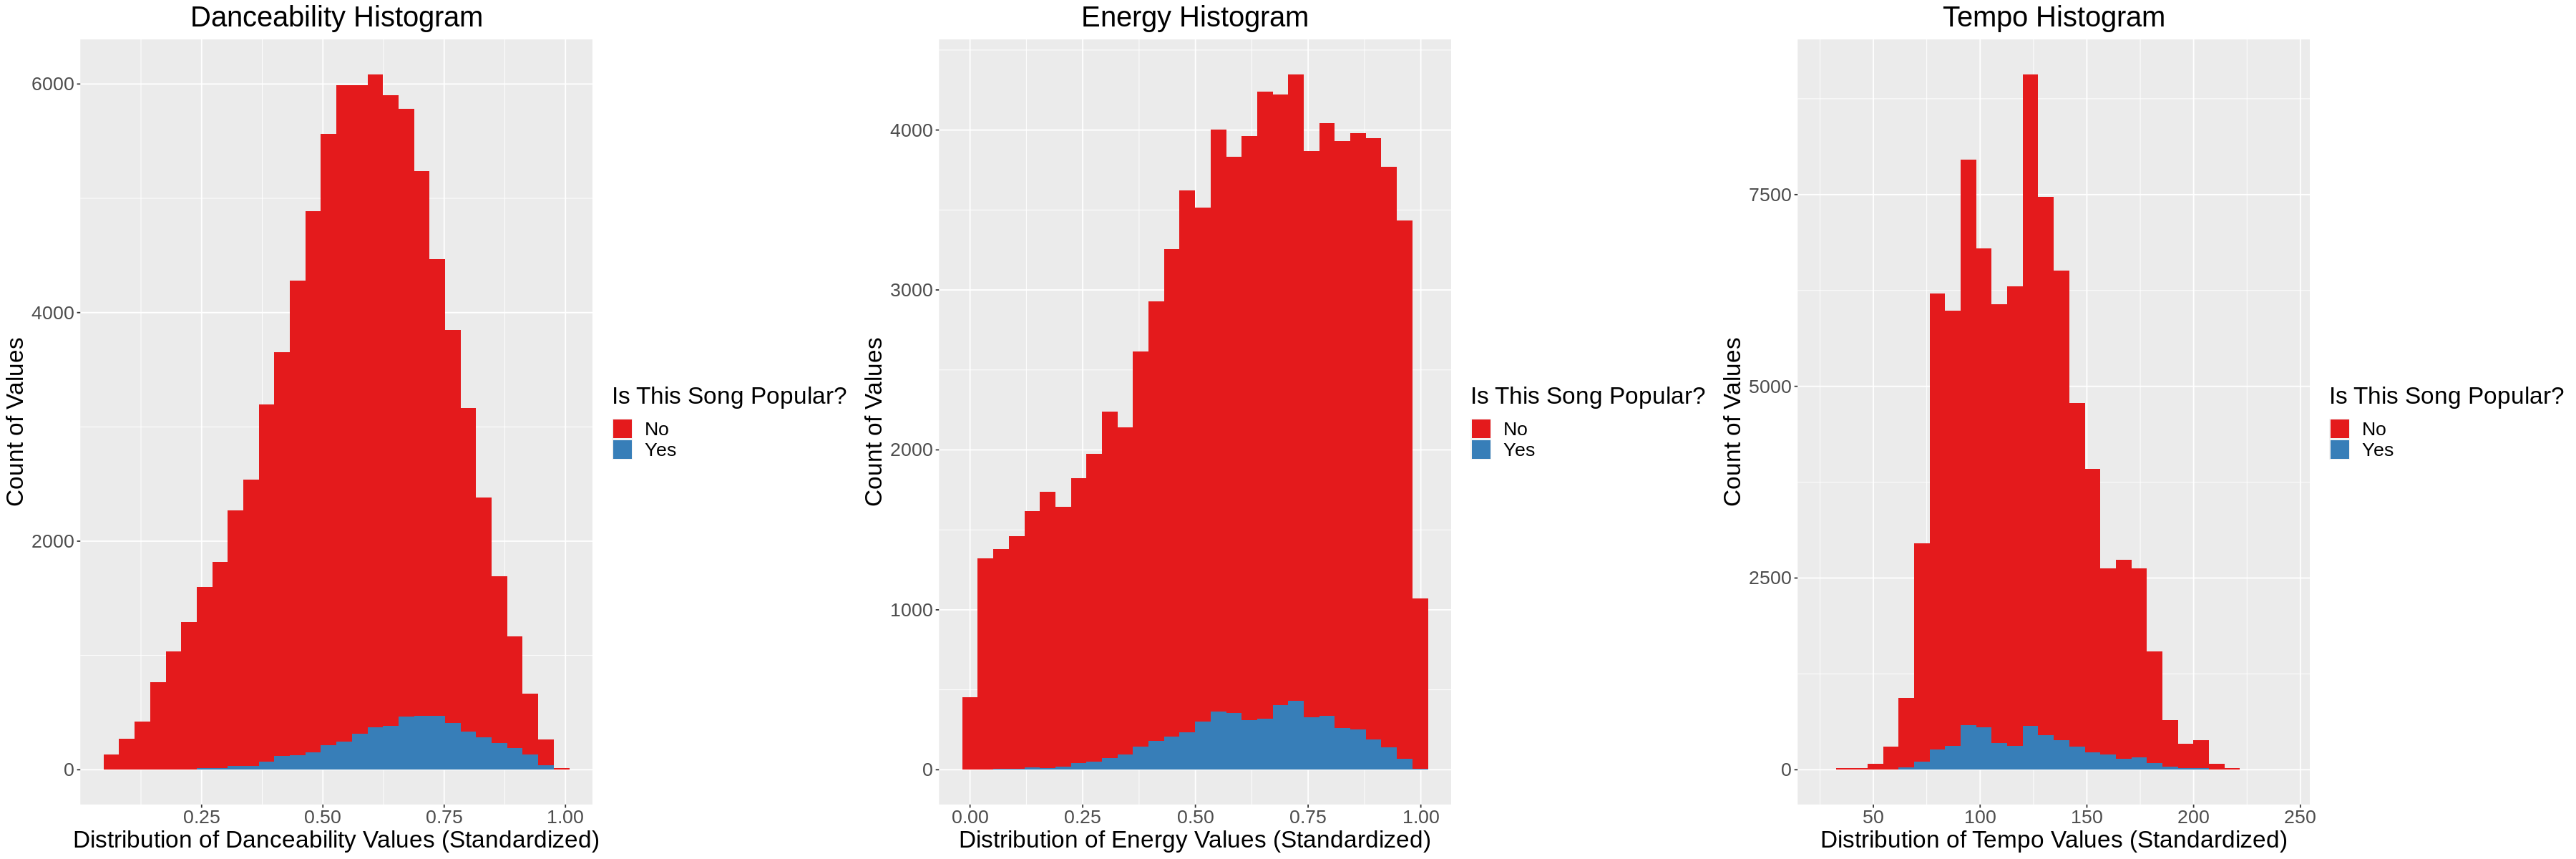

In [269]:
danceability_histogram = spotify_train %>%
                        ggplot(aes(x = danceability, fill = popular)) +
                        geom_histogram() +
                        labs(x = "Distribution of Danceability Values (Standardized)", y = "Count of Values"
                            , fill = "Is This Song Popular?") + 
                        ggtitle("Danceability Histogram") +
                        theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5)) + 
                        scale_fill_brewer(palette = "Set1")
                        
energy_histogram = spotify_train %>%
                        ggplot(aes(x = energy, fill = popular)) +
                        geom_histogram() +
                        labs(x = "Distribution of Energy Values (Standardized)", y = "Count of Values"
                             , fill = "Is This Song Popular?") + 
                        ggtitle("Energy Histogram") +
                        theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5)) + 
                        scale_fill_brewer(palette = "Set1")

tempo_histogram = spotify_train %>%
                        ggplot(aes(x = tempo, fill = popular)) +
                        geom_histogram() +
                        labs(x = "Distribution of Tempo Values (Standardized)", y = "Count of Values"
                            , fill = "Is This Song Popular?") + 
                        ggtitle("Tempo Histogram") +
                        theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5)) + 
                        scale_fill_brewer(palette = "Set1")

plot_grid(danceability_histogram, energy_histogram, tempo_histogram, ncol = 3)

We can see that danceability and tempo values follow a normal distribution, while the energy distibutions are skewed to the right.

## Part 3: Methods

**How will we coduct our data analysis?**

We will follow this outline when conducting our data analysis:
- Step #1: Create a KNN model specification
- Step #2: Train the model using our training dataset
- Step #3: Make our predictions

**Which variables are most important for our analysis?**

We expect to rely primarily on the following quantitative variables to predict popularity: danceability, energy, and tempo. 

**How will we visualize results?**

As our prediction algorithm will be dealing with quantitative data, a scatterplot will be useful for visualizing the datapoints within our dataset.

## Part 4: Expected Outcomes and Significance

**What do we expect to find?**

At first glance, we expect to find that new songs with higher ratings of danceability, energy, and tempo will likely score higher in popularity compared to songs that have lower ratings in these predictive variables. However, it will be interesting to dive further into this analysis and it is our hope that our assumptions will be challenged and stretched.

**What impact could these findings have?**

Our findings could help artists and producers understand the metrics that make music listeners really connect with a song. Making music is both an art and a science, and we hope that our analysis can provide artists and producers with the potential to uncover insights to help them create new music that will resonate with listeners on Spotify and other streaming services.

**What future questions could this lead to?**

As this dataset is unique to the listening habits of Spotify users, it would be interesting to compare these results with data from other popular streaming services, like Apple Music, Amazon Music, and Youtube Music, respectively.